# **BASIC MODEL FOR SENTIMENT ANALYSIS USING SUBWORDS**

IMPORT LIBRARIES

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

GET THE DATASET

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P \
    -O /tmp/sentiment.csv

--2023-03-07 14:04:54--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 142.251.163.139, 142.251.163.102, 142.251.163.100, ...
Connecting to drive.google.com (drive.google.com)|142.251.163.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5dce1no1csk4e057u60aic3a3u5dl88v/1678197825000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=0c5ae168-0a36-4547-8cf6-e4de72e40a5f [following]
--2023-03-07 14:04:55--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5dce1no1csk4e057u60aic3a3u5dl88v/1678197825000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=0c5ae168-0a36-4547-8cf6-e4de72e40a5f
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 172.253.115.132, 2607:f8b0:4004:c06::84
Connecting to d

LOAD THE DATASET

In [3]:
import pandas as pd

dataset = pd.read_csv('/tmp/sentiment.csv')

# Just extract out sentences and labels first - we will create subwords here
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

CREATE SUBWORDS DATASET

+ We can use the existing Amazon and Yelp reviews dataset 
+ with tensorflow_datasets's `SubwordTextEncoder` functionality.
+ `SubwordTextEncoder.build_from_corpus()` will create a tokenizer. 
+ We can also use this functionality to get subwords from a much larger corpus of text as well.
+ we'll create a subword vocab_size = 1,000 most common words, 
+ as well as cutting off each subword to be at most 5 characters.

In [4]:
import tensorflow_datasets as tfds

vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, 
                                                                      vocab_size, 
                                                                      max_subword_length=5)

In [5]:
# Check that the tokenizer works appropriately
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)
# Separately print out each subword, decoded
for i in encoded:
  print(tokenizer.decode([i]))

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]
I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


REPLACE SENTENCE DATA WITH ENCODED SUBWORDS

+ Re-create the dataset to be used for training by actually encoding each of the individual sentences. 
+ This is equivalent to text_to_sequences with the Tokenizer we used in earlier exercises.

In [6]:
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

# Check the sentences are appropriately replaced
print(sentences[1])

[625, 677, 626, 274, 380, 633, 148, 844, 789]


PREPROCESSING THE DATA

In [7]:
import numpy as np

max_length = 50
trunc_type='post'
padding_type='post'

# Pad all sentences
sentences_padded = pad_sequences(sentences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences_padded[0:training_size]
testing_sentences = sentences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

BUILD THE MODEL

In [8]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            16000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


COMPILE AND TRAIN THE MODEL

In [9]:
num_epochs = 100
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_sentences, training_labels_final, epochs=num_epochs, 
                    validation_data=(testing_sentences, testing_labels_final))

Epoch 1/100
50/50 [==============================] - 3s 17ms/step - loss: 0.6922 - accuracy: 0.5267 - val_loss: 0.6958 - val_accuracy: 0.4185
Epoch 2/100
50/50 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.5411 - val_loss: 0.6956 - val_accuracy: 0.4561
Epoch 3/100
50/50 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.5813 - val_loss: 0.6897 - val_accuracy: 0.5063
Epoch 4/100
50/50 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.6095 - val_loss: 0.6830 - val_accuracy: 0.5414
Epoch 5/100
50/50 [==============================] - 0s 3ms/step - loss: 0.6586 - accuracy: 0.6855 - val_loss: 0.6783 - val_accuracy: 0.5288
Epoch 6/100
50/50 [==============================] - 0s 4ms/step - loss: 0.6346 - accuracy: 0.7050 - val_loss: 0.6461 - val_accuracy: 0.6842
Epoch 7/100
50/50 [==============================] - 0s 3ms/step - loss: 0.6028 - accuracy: 0.7608 - val_loss: 0.6238 - val_accuracy: 0.7093
Epoch 8/100


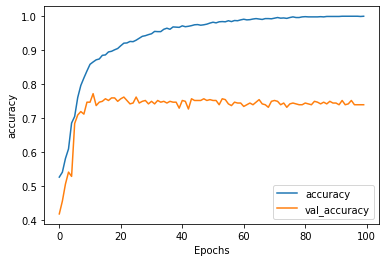

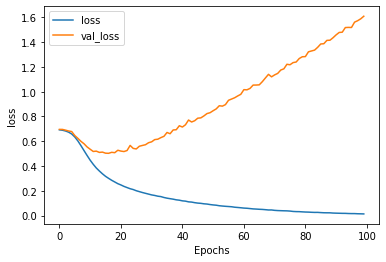

In [10]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

GET THE FILES FOR VISUALIZATION

In [11]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(1000, 16)


In [12]:
import io

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(0, vocab_size - 1):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [13]:
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

***